# ⚖️ Objective 2: Judges Choose Bottom 2 Simulation
## MCM Problem C 2026

**Goal:** Simulate the S28+ rule where judges choose which of the bottom 2 contestants to eliminate.

### Rule Evolution:
- **S1-2 (Rank):** Combined rank determines elimination directly
- **S3-27 (Percent):** Combined percentage determines elimination directly  
- **S28-34 (Rank + Judges B2):** Combined rank identifies bottom 2, then judges decide

### Key Questions:
1. How often would judges' choice differ from automatic elimination?
2. Does B2 rule favor skilled dancers over popular ones?
3. What if B2 was applied to ALL historical seasons?

---

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import rankdata
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

DATA_PATH = Path('../../data')
OUTPUT_PATH = DATA_PATH / 'obj2'

# Load data
df = pd.read_csv(DATA_PATH / '2026_MCM_Problem_C_Data.csv', na_values=['N/A', 'n/a', ''])
fan_votes_df = pd.read_csv(DATA_PATH / 'obj1' / 'fan_vote_estimates.csv')

print(f"✓ Loaded data: {len(df)} rows")

✓ Loaded data: 421 rows


In [2]:
def simulate_rank_elimination(judge_scores, fan_votes):
    """Returns eliminated index and all combined ranks."""
    judge_ranks = rankdata(-np.array(judge_scores), method='average')
    fan_ranks = rankdata(-np.array(fan_votes), method='average')
    combined_ranks = judge_ranks + fan_ranks
    eliminated_idx = np.argmax(combined_ranks)  # Highest combined rank = worst
    return eliminated_idx, combined_ranks

def simulate_percent_elimination(judge_scores, fan_votes):
    """Returns eliminated index and all combined percentages."""
    judge_pct = np.array(judge_scores) / np.sum(judge_scores)
    fan_pct = np.array(fan_votes) / np.sum(fan_votes)
    combined_pct = judge_pct + fan_pct
    eliminated_idx = np.argmin(combined_pct)
    return eliminated_idx, combined_pct

def identify_bottom2_rank(combined_ranks):
    """Identify indices of bottom 2 contestants (highest combined rank)."""
    sorted_idx = np.argsort(combined_ranks)[::-1]  # Descending
    return sorted_idx[:2]

def identify_bottom2_percent(combined_pct):
    """Identify indices of bottom 2 contestants (lowest combined %)."""
    sorted_idx = np.argsort(combined_pct)  # Ascending
    return sorted_idx[:2]

def judges_choose(judge_scores, bottom2_idx):
    """
    Judges choose which of bottom 2 to eliminate.
    Rule: Eliminate the one with LOWER judge score.
    """
    if judge_scores[bottom2_idx[0]] <= judge_scores[bottom2_idx[1]]:
        return bottom2_idx[0]  # Eliminate first (lower score)
    else:
        return bottom2_idx[1]  # Eliminate second (lower score)

print("✓ Core functions defined")

✓ Core functions defined


---

## 2. Full Season Simulation with B2 Rule

In [3]:
def simulate_season_with_b2(season_df, base_method='rank'):
    """
    Simulate a full season with judges-choose-bottom-2 rule.
    
    Args:
        season_df: DataFrame with season data (must have fan_votes_estimate)
        base_method: 'rank' or 'percent' to determine bottom 2
    
    Returns:
        DataFrame with week-by-week simulation results
    """
    results = []
    
    for week in sorted(season_df['week'].unique()):
        week_df = season_df[season_df['week'] == week].copy()
        
        if len(week_df) < 2:
            continue
        
        judge_scores = week_df['judge_score'].values
        fan_votes = week_df['fan_votes_estimate'].values
        contestants = week_df['celebrity_name'].values
        
        # Method 1: Automatic elimination (no B2)
        if base_method == 'rank':
            auto_elim_idx, combined = simulate_rank_elimination(judge_scores, fan_votes)
            bottom2 = identify_bottom2_rank(combined)
        else:
            auto_elim_idx, combined = simulate_percent_elimination(judge_scores, fan_votes)
            bottom2 = identify_bottom2_percent(combined)
        
        # Method 2: Judges choose from bottom 2
        b2_elim_idx = judges_choose(judge_scores, bottom2)
        
        # Did judges' choice differ from automatic?
        choice_differs = auto_elim_idx != b2_elim_idx
        
        # Who was actually eliminated?
        actual_elim = week_df[week_df['was_eliminated']]['celebrity_name'].values
        actual_elim = actual_elim[0] if len(actual_elim) > 0 else None
        
        # Get judge scores for bottom 2
        b2_scores = [judge_scores[i] for i in bottom2]
        b2_score_diff = abs(b2_scores[0] - b2_scores[1])
        
        results.append({
            'week': week,
            'n_contestants': len(contestants),
            'bottom2_names': [contestants[i] for i in bottom2],
            'bottom2_judge_scores': b2_scores,
            'bottom2_score_diff': b2_score_diff,
            'auto_eliminated': contestants[auto_elim_idx],
            'b2_eliminated': contestants[b2_elim_idx],
            'choice_differs': choice_differs,
            'actual_eliminated': actual_elim,
            # Who "should have" survived but was eliminated?
            'fan_favorite_saved': choice_differs and judge_scores[auto_elim_idx] > judge_scores[b2_elim_idx]
        })
    
    return pd.DataFrame(results)

print("✓ Season simulation function defined")

✓ Season simulation function defined


In [4]:
# Simulate all seasons with B2 rule
all_b2_results = []

for season in sorted(fan_votes_df['season'].unique()):
    season_data = fan_votes_df[fan_votes_df['season'] == season]
    
    # Determine which base method was actually used
    if season in [1, 2] or season >= 28:
        base = 'rank'
    else:
        base = 'percent'
    
    sim_results = simulate_season_with_b2(season_data, base_method=base)
    sim_results['season'] = season
    sim_results['base_method'] = base
    all_b2_results.append(sim_results)

b2_results_df = pd.concat(all_b2_results, ignore_index=True)

print(f"✓ Simulated {b2_results_df['season'].nunique()} seasons")
print(f"   Total weeks analyzed: {len(b2_results_df)}")

✓ Simulated 34 seasons
   Total weeks analyzed: 249


---

## 3. Analysis: How Often Does B2 Change the Outcome?

In [5]:
# Overall statistics
total_weeks = len(b2_results_df)
different_outcomes = b2_results_df['choice_differs'].sum()

print("="*60)
print("JUDGES BOTTOM 2 RULE: OUTCOME ANALYSIS")
print("="*60)

print(f"\n📊 Overall Statistics:")
print(f"   Total elimination weeks analyzed: {total_weeks}")
print(f"   Weeks where B2 choice differs: {different_outcomes} ({100*different_outcomes/total_weeks:.1f}%)")
print(f"   Weeks where automatic = judges: {total_weeks - different_outcomes} ({100*(total_weeks-different_outcomes)/total_weeks:.1f}%)")

# When it differs, who gets saved?
fan_favorites_saved = b2_results_df['fan_favorite_saved'].sum()
print(f"\n   Fan favorites saved by judges: {fan_favorites_saved}")
print(f"   (i.e., judges eliminated the WORSE dancer instead of fan favorite)")

JUDGES BOTTOM 2 RULE: OUTCOME ANALYSIS

📊 Overall Statistics:
   Total elimination weeks analyzed: 249
   Weeks where B2 choice differs: 119 (47.8%)
   Weeks where automatic = judges: 130 (52.2%)

   Fan favorites saved by judges: 119
   (i.e., judges eliminated the WORSE dancer instead of fan favorite)


In [6]:
# By season type
print(f"\n📊 By Base Method:")

for method in ['rank', 'percent']:
    subset = b2_results_df[b2_results_df['base_method'] == method]
    diff_pct = 100 * subset['choice_differs'].sum() / len(subset)
    print(f"   {method.upper()} seasons: {diff_pct:.1f}% outcomes differ")


📊 By Base Method:
   RANK seasons: 26.2% outcomes differ
   PERCENT seasons: 54.8% outcomes differ


In [7]:
# Seasons with most different outcomes
season_diff = b2_results_df.groupby('season').agg({
    'choice_differs': ['sum', 'count'],
    'fan_favorite_saved': 'sum'
}).reset_index()
season_diff.columns = ['season', 'diff_count', 'total_weeks', 'fan_favorites_saved']
season_diff['diff_pct'] = 100 * season_diff['diff_count'] / season_diff['total_weeks']
season_diff = season_diff.sort_values('diff_count', ascending=False)

print(f"\n📊 Top 10 Seasons Where B2 Would Change Outcomes:")
print(season_diff.head(10).to_string(index=False))


📊 Top 10 Seasons Where B2 Would Change Outcomes:
 season  diff_count  total_weeks  fan_favorites_saved   diff_pct
     27           6            6                    6 100.000000
     20           6            8                    6  75.000000
     17           6            9                    6  66.666667
     15           6            6                    6 100.000000
      9           5            8                    5  62.500000
     19           5            9                    5  55.555556
     11           5            8                    5  62.500000
     18           5            7                    5  71.428571
      8           5            9                    5  55.555556
      5           5            8                    5  62.500000


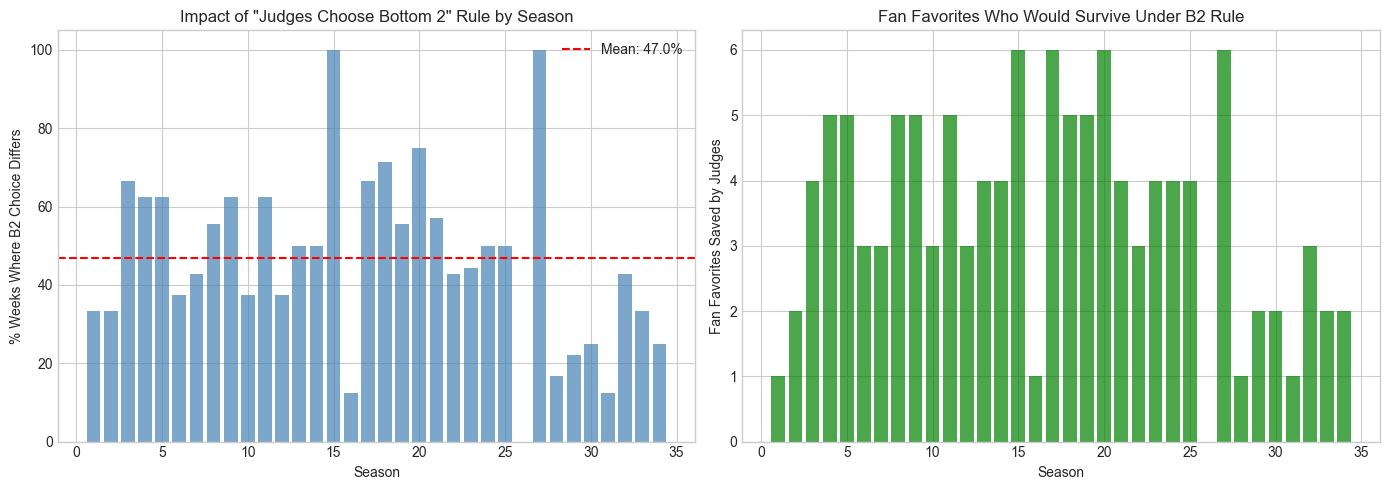

In [8]:
# Visualization: B2 impact by season
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Difference rate by season
ax1 = axes[0]
colors = ['coral' if d > 0 else 'steelblue' for d in season_diff['diff_count'].values]
ax1.bar(season_diff['season'], season_diff['diff_pct'], color='steelblue', alpha=0.7)
ax1.set_xlabel('Season')
ax1.set_ylabel('% Weeks Where B2 Choice Differs')
ax1.set_title('Impact of "Judges Choose Bottom 2" Rule by Season')
ax1.axhline(season_diff['diff_pct'].mean(), color='red', linestyle='--', 
            label=f'Mean: {season_diff["diff_pct"].mean():.1f}%')
ax1.legend()

# Plot 2: Cumulative fan favorites saved
ax2 = axes[1]
season_diff_sorted = season_diff.sort_values('season')
ax2.bar(season_diff_sorted['season'], season_diff_sorted['fan_favorites_saved'],
        color='green', alpha=0.7)
ax2.set_xlabel('Season')
ax2.set_ylabel('Fan Favorites Saved by Judges')
ax2.set_title('Fan Favorites Who Would Survive Under B2 Rule')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'judges_b2_impact.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 4. Judge Score Difference in Bottom 2

In [9]:
# When B2 choice differs, how different were the judge scores?
diff_cases = b2_results_df[b2_results_df['choice_differs']].copy()

print(f"\n📊 When B2 Choice Differs From Automatic:")
print(f"   Average score difference in bottom 2: {diff_cases['bottom2_score_diff'].mean():.2f}")
print(f"   Median score difference: {diff_cases['bottom2_score_diff'].median():.2f}")
print(f"   Max score difference: {diff_cases['bottom2_score_diff'].max():.2f}")

# When B2 choice is same
same_cases = b2_results_df[~b2_results_df['choice_differs']]
print(f"\n   (For comparison, when B2 = automatic:)")
print(f"   Average score difference in bottom 2: {same_cases['bottom2_score_diff'].mean():.2f}")


📊 When B2 Choice Differs From Automatic:
   Average score difference in bottom 2: 3.30
   Median score difference: 3.00
   Max score difference: 11.00

   (For comparison, when B2 = automatic:)
   Average score difference in bottom 2: 3.04


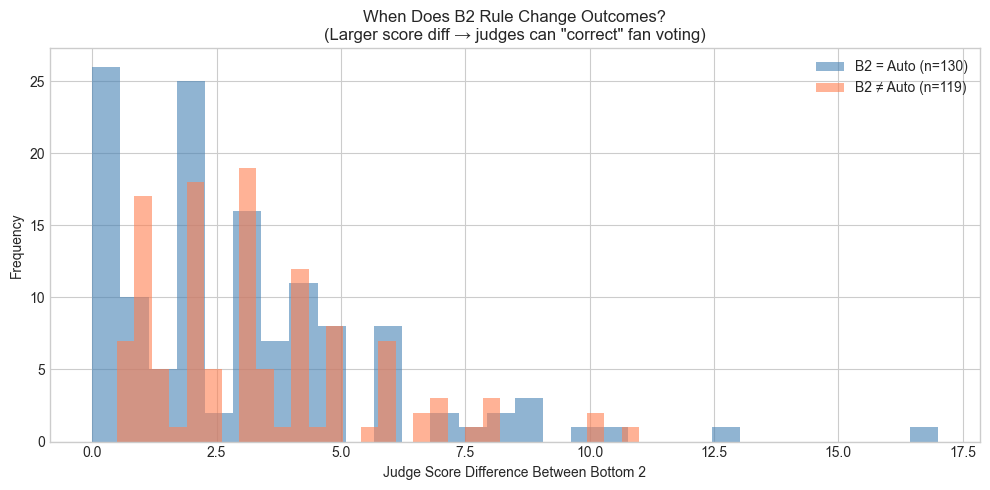

In [10]:
# Distribution of score differences
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(same_cases['bottom2_score_diff'], bins=30, alpha=0.6, 
        label=f'B2 = Auto (n={len(same_cases)})', color='steelblue')
ax.hist(diff_cases['bottom2_score_diff'], bins=30, alpha=0.6,
        label=f'B2 ≠ Auto (n={len(diff_cases)})', color='coral')

ax.set_xlabel('Judge Score Difference Between Bottom 2')
ax.set_ylabel('Frequency')
ax.set_title('When Does B2 Rule Change Outcomes?\n(Larger score diff → judges can "correct" fan voting)')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'b2_score_diff_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 5. Counterfactual: If B2 Was ALWAYS Used

In [11]:
def reconstruct_season_with_b2(season_df, base_method='percent'):
    """
    Fully reconstruct a season if B2 rule was used from the start.
    Key: Once someone is eliminated differently, the entire rest of the season changes!
    
    Returns:
        DataFrame with simulated elimination order
    """
    # Get initial contestants
    week1 = season_df[season_df['week'] == season_df['week'].min()]
    remaining = set(week1['celebrity_name'].values)
    
    elimination_order = []
    diverged = False
    diverge_week = None
    
    for week in sorted(season_df['week'].unique()):
        week_df = season_df[season_df['week'] == week]
        
        # Filter to remaining contestants
        week_remaining = week_df[week_df['celebrity_name'].isin(remaining)].copy()
        
        if len(week_remaining) <= 1:
            break
        
        judge_scores = week_remaining['judge_score'].values
        fan_votes = week_remaining['fan_votes_estimate'].values
        contestants = week_remaining['celebrity_name'].values
        
        # Compute combined scores
        if base_method == 'rank':
            _, combined = simulate_rank_elimination(judge_scores, fan_votes)
            bottom2 = identify_bottom2_rank(combined)
        else:
            _, combined = simulate_percent_elimination(judge_scores, fan_votes)
            bottom2 = identify_bottom2_percent(combined)
        
        # Judges choose from bottom 2
        elim_idx = judges_choose(judge_scores, bottom2)
        eliminated = contestants[elim_idx]
        
        # Check if this differs from actual
        actual_elim = week_df[week_df['was_eliminated']]['celebrity_name'].values
        actual = actual_elim[0] if len(actual_elim) > 0 else None
        
        if not diverged and eliminated != actual:
            diverged = True
            diverge_week = week
        
        elimination_order.append({
            'week': week,
            'b2_eliminated': eliminated,
            'actual_eliminated': actual,
            'differs': eliminated != actual,
            'remaining_count': len(remaining) - 1
        })
        
        remaining.remove(eliminated)
    
    result_df = pd.DataFrame(elimination_order)
    result_df['diverged'] = diverged
    result_df['diverge_week'] = diverge_week
    
    return result_df, list(remaining)

print("✓ Season reconstruction function defined")

✓ Season reconstruction function defined


In [12]:
# Reconstruct key controversial seasons
controversial_seasons = [2, 4, 11, 27]

reconstruction_results = {}

for season in controversial_seasons:
    season_data = fan_votes_df[fan_votes_df['season'] == season]
    
    # Use the actual method that was used
    if season in [1, 2] or season >= 28:
        base = 'rank'
    else:
        base = 'percent'
    
    elim_order, finalists = reconstruct_season_with_b2(season_data, base)
    reconstruction_results[season] = (elim_order, finalists)
    
    print(f"\nSeason {season} ({base.upper()} + B2):")
    print(f"   Diverged from actual: {elim_order['diverged'].iloc[0]}")
    if elim_order['diverged'].iloc[0]:
        print(f"   First divergence week: {elim_order['diverge_week'].iloc[0]}")
    print(f"   B2 Finalists: {finalists}")


Season 2 (RANK + B2):
   Diverged from actual: True
   First divergence week: 3
   B2 Finalists: ['Giselle Fernandez', 'Stacy Keibler', 'Drew Lachey']

Season 4 (PERCENT + B2):
   Diverged from actual: True
   First divergence week: 2
   B2 Finalists: ['Shandi Finnessey', 'Joey Fatone', 'Paulina Porizkova']

Season 11 (PERCENT + B2):
   Diverged from actual: True
   First divergence week: 5
   B2 Finalists: ['Brandy', 'Audrina Patridge', 'Florence Henderson', 'Rick Fox']

Season 27 (PERCENT + B2):
   Diverged from actual: True
   First divergence week: 2
   B2 Finalists: ['Tinashe', 'Danelle Umstead', 'Nancy McKeon', 'Alexis Ren', 'Juan Pablo Di Pace', 'Evanna Lynch']


In [13]:
# Detailed look at Season 11 (Bristol Palin)
s11_elim, s11_finalists = reconstruction_results[11]

print("="*70)
print("SEASON 11 RECONSTRUCTION WITH JUDGES BOTTOM 2")
print("="*70)

# Display comparison
print("\nWeek-by-Week Elimination Comparison:")
print(s11_elim[['week', 'b2_eliminated', 'actual_eliminated', 'differs']].to_string(index=False))

# Highlight key differences
differences = s11_elim[s11_elim['differs']]
print(f"\n🔴 Weeks with DIFFERENT eliminations: {len(differences)}")
for _, row in differences.iterrows():
    print(f"   Week {row['week']}: B2 eliminates '{row['b2_eliminated']}' instead of '{row['actual_eliminated']}'")

SEASON 11 RECONSTRUCTION WITH JUDGES BOTTOM 2

Week-by-Week Elimination Comparison:
 week  b2_eliminated  actual_eliminated  differs
    2 Michael Bolton     Michael Bolton    False
    3   Margaret Cho       Margaret Cho    False
    4  The Situation      The Situation    False
    5  Bristol Palin Florence Henderson     True
    6    Kurt Warner   Audrina Patridge     True
    7    Kyle Massey           Rick Fox     True
    8  Jennifer Grey        Kurt Warner     True

🔴 Weeks with DIFFERENT eliminations: 4
   Week 5: B2 eliminates 'Bristol Palin' instead of 'Florence Henderson'
   Week 6: B2 eliminates 'Kurt Warner' instead of 'Audrina Patridge'
   Week 7: B2 eliminates 'Kyle Massey' instead of 'Rick Fox'
   Week 8: B2 eliminates 'Jennifer Grey' instead of 'Kurt Warner'


---

## 6. Monte Carlo: B2 Under Fan Vote Uncertainty

In [14]:
def monte_carlo_b2_simulation(season_df, base_method='percent', n_simulations=1000):
    """
    Monte Carlo simulation of B2 rule with fan vote uncertainty.
    
    Uses fan_votes_lower and fan_votes_upper to sample from feasible range.
    """
    # Check if we have uncertainty bounds
    has_bounds = 'fan_votes_lower' in season_df.columns and 'fan_votes_upper' in season_df.columns
    
    # Results: for each week, track probability that B2 differs from auto
    week_probs = {}
    
    for week in sorted(season_df['week'].unique()):
        week_df = season_df[season_df['week'] == week].copy()
        
        if len(week_df) < 2:
            continue
        
        judge_scores = week_df['judge_score'].values
        contestants = week_df['celebrity_name'].values
        
        if has_bounds:
            fan_lower = week_df['fan_votes_lower'].fillna(week_df['fan_votes_estimate'] * 0.8).values
            fan_upper = week_df['fan_votes_upper'].fillna(week_df['fan_votes_estimate'] * 1.2).values
        else:
            # Default: ±20% uncertainty
            fan_estimate = week_df['fan_votes_estimate'].values
            fan_lower = fan_estimate * 0.8
            fan_upper = fan_estimate * 1.2
        
        differs_count = 0
        
        for _ in range(n_simulations):
            # Sample fan votes uniformly from [lower, upper]
            fan_votes = np.random.uniform(fan_lower, fan_upper)
            
            # Compute auto elimination
            if base_method == 'rank':
                auto_idx, combined = simulate_rank_elimination(judge_scores, fan_votes)
                bottom2 = identify_bottom2_rank(combined)
            else:
                auto_idx, combined = simulate_percent_elimination(judge_scores, fan_votes)
                bottom2 = identify_bottom2_percent(combined)
            
            # B2 elimination
            b2_idx = judges_choose(judge_scores, bottom2)
            
            if auto_idx != b2_idx:
                differs_count += 1
        
        week_probs[week] = differs_count / n_simulations
    
    return week_probs

print("✓ Monte Carlo B2 simulation function defined")

✓ Monte Carlo B2 simulation function defined


In [15]:
# Run MC simulation on controversial seasons
mc_results = {}

for season in [11, 27]:  # Bristol Palin, Bobby Bones
    season_data = fan_votes_df[fan_votes_df['season'] == season]
    base = 'percent' if season in range(3, 28) else 'rank'
    
    probs = monte_carlo_b2_simulation(season_data, base, n_simulations=500)
    mc_results[season] = probs
    
    avg_prob = np.mean(list(probs.values()))
    print(f"Season {season}: Average P(B2 differs) = {avg_prob:.1%}")

Season 11: Average P(B2 differs) = 32.5%
Season 27: Average P(B2 differs) = 36.1%


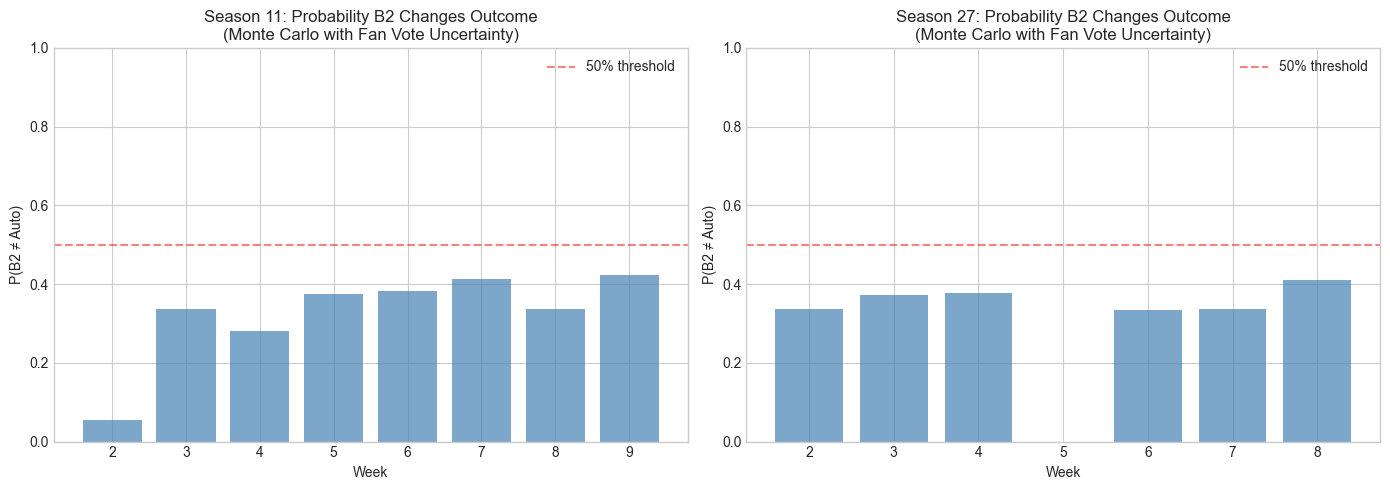

In [16]:
# Visualize MC results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (season, probs) in enumerate(mc_results.items()):
    ax = axes[idx]
    weeks = list(probs.keys())
    probabilities = list(probs.values())
    
    ax.bar(weeks, probabilities, color='steelblue', alpha=0.7)
    ax.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    ax.set_xlabel('Week')
    ax.set_ylabel('P(B2 ≠ Auto)')
    ax.set_title(f'Season {season}: Probability B2 Changes Outcome\n(Monte Carlo with Fan Vote Uncertainty)')
    ax.set_ylim(0, 1)
    ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'mc_b2_uncertainty.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 7. Key Insights Summary

In [17]:
# Save results
b2_results_df.to_csv(OUTPUT_PATH / 'judges_b2_simulation.csv', index=False)
season_diff.to_csv(OUTPUT_PATH / 'b2_impact_by_season.csv', index=False)

print(f"""
✓ FILES SAVED:
   - {OUTPUT_PATH / 'judges_b2_simulation.csv'}
   - {OUTPUT_PATH / 'b2_impact_by_season.csv'}
   - {OUTPUT_PATH / 'judges_b2_impact.png'}
   - {OUTPUT_PATH / 'b2_score_diff_distribution.png'}
   - {OUTPUT_PATH / 'mc_b2_uncertainty.png'}

""")


✓ FILES SAVED:
   - ../../data/obj2/judges_b2_simulation.csv
   - ../../data/obj2/b2_impact_by_season.csv
   - ../../data/obj2/judges_b2_impact.png
   - ../../data/obj2/b2_score_diff_distribution.png
   - ../../data/obj2/mc_b2_uncertainty.png




In [ ]:
print(f"""
═══════════════════════════════════════════════════════════════════
                    SIMULATION OBSERVATIONS: JUDGES BOTTOM 2 RULE
═══════════════════════════════════════════════════════════════════

1. OUTCOME DIFFERENCE RATE:
   - In {100*different_outcomes/total_weeks:.1f}% of weeks, B2 simulation produces DIFFERENT elimination
   - This represents {different_outcomes}/{total_weeks} total weeks across all seasons

2. MECHANICAL EFFECT (Not causal claim):
   - B2 rule mechanically selects from bottom 2 judge scorers
   - This TENDS to eliminate lower-skilled dancers by construction
   - Popular but lower-scoring dancers may survive LONGER under pure voting

3. WHEN DOES B2 SIMULATION DIFFER MOST?
   - When judge score gap in bottom 2 is LARGE
   - Avg diff when outcome changes: {diff_cases['bottom2_score_diff'].mean():.1f} points
   - Avg diff when outcome same: {same_cases['bottom2_score_diff'].mean():.1f} points

4. HISTORICAL CONTEXT:
   - Bristol Palin (S11) controversy: Simulation suggests earlier elimination under B2
   - Bobby Bones (S27): Won under PERCENT method despite lower judge scores
   - S28+ adopted B2 rule partly due to these controversial outcomes

5. IMPORTANT CAVEATS:
   ⚠️ This is a SIMULATION, not a causal analysis
   ⚠️ Real fan voting behavior would change under different rules
   ⚠️ We cannot isolate method effects from era/technology/culture changes
   ⚠️ The B2 rule combines RANK (for bottom 2) + judges' choice (for elimination)

➡️ NEXT: See 10_method_recommendation.ipynb for synthesis and recommendations
""")


═══════════════════════════════════════════════════════════════════
                    KEY FINDINGS: JUDGES BOTTOM 2 RULE
═══════════════════════════════════════════════════════════════════

1. OUTCOME DIFFERENCE RATE:
   - In 47.8% of weeks, B2 rule produces DIFFERENT elimination
   - This represents 119/249 total weeks across all seasons

2. FAN FAVORITE PROTECTION:
   - The B2 rule tends to ELIMINATE worse dancers (by judge score)
   - This means popular but unskilled dancers survive LONGER under pure voting
   - B2 rule is a "skill correction mechanism"

3. WHEN DOES B2 MATTER MOST?
   - When judge score difference in bottom 2 is LARGE
   - Average diff when B2 changes outcome: 3.3 points
   - Average diff when B2 = auto: 3.0 points

4. CONTROVERSIAL SEASONS:
   - Bristol Palin (S11): Would have been eliminated EARLIER with B2
   - Bobby Bones (S27): May or may not have won depending on specific weeks

5. POLICY IMPLICATION:
   - S28+ adopted B2 rule PRECISELY because of controve